# Separating Particulate and Dissolved Constituents from Flowthrough ACS Data



In [1]:
from datetime import datetime
import gsw
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import numpy as np
import xarray as xr

from acspype import ACSDev, ACSTSCor
import acspype.processing as acsproc
import acspype.qaqc as acsqaqc
from acspype.experimental import estimate_chl

This notebook demonstrates processing ACS data and separating the particulate and gelbstoff signals using Xarray. This requires a merged dataset that contains information about the filtration state, the location, temperature, and salinity of the seawater sample. For this example, a seawater_state value of 0 indicates total seawater (particulate + gelbstoff) and a value of 1 indicates filtered seawater that has been filtered through a 0.2 micron filter (gelbstoff).

You can replicate this example by downloading the subset dataset and device file from [Kaggle](https://www.kaggle.com/datasets/blackia/shimada202405-subset-acs) and modifying the filepath locations to match your system.

In [2]:
data_fp = '../dev_tools/test_files/shimada_202405_subset.nc'
dev_fp = '../dev_tools/test_files/ACS-00412_2023-05-10.dev'

## Load the ACS Data, Device File, and TSCor Coefficients.

In [3]:
acs = xr.open_dataset(data_fp)
dev = ACSDev(dev_fp)

In [4]:
tscor = ACSTSCor().to_xarray()  ## Load the TSCor coefficients as an xarray dataset.

# TSCor coeffs for absorption.
psi_t_a = tscor.psi_t.sel(wavelength=acs.a_wavelength)
psi_s_a = tscor.psi_s_a.sel(wavelength=acs.a_wavelength)

# TSCor coeffs for attenuation.
psi_t_c = tscor.psi_t.sel(wavelength=acs.c_wavelength)
psi_s_c = tscor.psi_s_c.sel(wavelength=acs.c_wavelength)

## Reprocess Data

See the [Recommended Processing Steps](https://github.com/IanTBlack/acspype/blob/main/info/PROCESSING.md) for additional information.

In [5]:
acs['internal_temperature'] = acsproc.compute_internal_temperature(counts = acs.raw_internal_temperature)

In [6]:
sea_water_pressure = 3 # Assume flowthrough intake is ~3 dbars (meters) below the average water line.

acs['sea_water_absolute_salinity'] = gsw.SA_from_SP(SP = acs.sea_water_practical_salinity,
                                                    p =sea_water_pressure, 
                                                    lon = acs.longitude, 
                                                    lat = acs.latitude)

acs['sea_water_conservative_temperature'] = gsw.CT_from_t(SA=acs.sea_water_absolute_salinity, 
                                                          t = acs.sea_water_temperature, 
                                                          p=sea_water_pressure)

In [7]:
acs['a_uncorrected'] = acsproc.compute_uncorrected(signal_counts=acs.a_signal,
                                                   reference_counts=acs.a_reference, 
                                                   path_length = dev.path_length)

acs['c_uncorrected'] = acsproc.compute_uncorrected(signal_counts = acs.c_signal, 
                                                   reference_counts = acs.c_reference, 
                                                   path_length = dev.path_length)

In [8]:
acs['a_m_discontinuity'] = acsproc.compute_measured(uncorrected = acs.a_uncorrected, 
                                                    internal_temperature = acs.internal_temperature, 
                                                    offset = dev.a_offset, 
                                                    func_delta_t = dev.func_a_delta_t)
acs['c_m_discontinuity'] = acsproc.compute_measured(uncorrected = acs.c_uncorrected, 
                                                    internal_temperature = acs.internal_temperature, 
                                                    offset = dev.c_offset, 
                                                    func_delta_t=dev.func_c_delta_t)

In [9]:
discontinuity_index = acsproc.find_discontinuity_index(a_wavelength = acs.a_wavelength, 
                                                       c_wavelength = acs.c_wavelength,
                                                       min_wvl = 500, max_wvl = 650)

acs['a_m'], acs['a_discontinuity_offset'] = acsproc.discontinuity_correction(measured = acs.a_m_discontinuity,
                                                                             discontinuity_index=discontinuity_index,
                                                                             wavelength_dim='a_wavelength')
acs['c_m'], acs['c_discontinuity_offset'] = acsproc.discontinuity_correction(measured = acs.c_m_discontinuity,
                                                                             discontinuity_index=discontinuity_index,
                                                                             wavelength_dim='c_wavelength')

In [10]:
tcal = dev.tcal  # The reference temperature value in the device file.

acs['a_mts'] = acsproc.ts_correction(measured = acs.a_m, 
                                     temperature = acs.sea_water_conservative_temperature,
                                     salinity = acs.sea_water_absolute_salinity, 
                                     psi_temperature = psi_t_a, 
                                     psi_salinity= psi_s_a, 
                                     tcal = tcal)
acs['c_mts'] = acsproc.ts_correction(measured = acs.c_m, 
                                     temperature = acs.sea_water_conservative_temperature,
                                     salinity = acs.sea_water_absolute_salinity, 
                                     psi_temperature= psi_t_c, 
                                     psi_salinity = psi_s_c, 
                                     tcal = tcal)

## Interpolate to Common Wavelengths

In [11]:
acs = acsproc.interpolate_common_wavelengths(ds = acs,
                                             a_wavelength_dim='a_wavelength',
                                             c_wavelength_dim='c_wavelength',
                                             new_wavelength_dim='wavelength',
                                             wavelength_range='infer',
                                             step = 1)

## Apply Proportional Scattering Correction

In [12]:
reference_wavelength = 715
acs = acs.sel(wavelength = slice(None, reference_wavelength))
a_715 = acs.a_mts.sel(wavelength = reference_wavelength, method = 'nearest')
c_715 = acs.c_mts.sel(wavelength = reference_wavelength, method = 'nearest')

acs['a_mts_proportional'] = acsproc.proportional_scattering_correction(a_mts = acs.a_mts, 
                                                                       c_mts = acs.c_mts, 
                                                                       reference_a = a_715, 
                                                                       reference_c = c_715) # Proportional Method from Zaneveld et al. 1994


## Apply Zero Shift

In [13]:
acs['c_mts'] = acsproc.zero_shift_correction(mts = acs.c_mts)
acs['a_mts_proportional'] = acsproc.zero_shift_correction(mts = acs.a_mts_proportional)

## Subset Data to Reduce Size
Depending on your computer specs, it might be a good idea to reduce the amount of data that is in memory.

In [14]:
acs = acs[['c_mts','a_mts_proportional', 'sea_water_conservative_temperature','sea_water_absolute_salinity','seawater_state','longitude','latitude',]]  # Subset data to reduce size.

## Split into Gelbstoff (g) and Total Seawater (pg) Data

In [15]:
g = acs.where(acs.seawater_state != 0, drop = True)

In [16]:
pg = acs.where(acs.seawater_state != 1, drop = True)

## Cleanup and Interpolate Filtered Periods

It may take a few minutes for the dissolved signal to stabilize after a filter change. The function in the next cell removes the first 5 minutes and last 30 seconds of a dissolved period.

In [17]:
def cleanup_filtered_periods(g: xr.DataArray, filter_period_length:int = 15 * 60, remove_start: int = 5 * 60, remove_end: int = 30):
    dt = g.where(g['time'].diff('time') > np.timedelta64(filter_period_length, 's'), drop=True).get_index('time')
    fperiods = []
    jback = np.timedelta64(60, 's')  # 30 second jump back to avoid collecting data from the following profile
    for i, d in enumerate(dt):
        # pull out the profile
        if i == 0:
            fperiod = g.sel(time=slice(g['time'].values[0], d - jback))
        else:
            fperiod = g.sel(time=slice(dt[i - 1], d - jback))
            
            
        fperiod = fperiod.sel(time = slice(fperiod.time.min() + np.timedelta64(remove_start,'s'), 
                                           fperiod.time.max() - np.timedelta64(remove_end,'s')))    
        
        if len(fperiod.time.values != 0):
            fperiods.append(fperiod)
    
        # grab the last profile and append it to the list
        fperiod = g.sel(time=slice(d, g['time'].values[-1]))
        fperiod = fperiod.sel(time = slice(fperiod.time.min() + np.timedelta64(remove_start,'s'), 
                                           fperiod.time.max() - np.timedelta64(remove_end,'s')))    

        if len(fperiod.time.values != 0):
            fperiods.append(fperiod)
    
    filtered = xr.concat(fperiods, dim = 'time')
    filtered = filtered.drop_duplicates(dim = 'time')
    return filtered
    

In [18]:
a_g = g.a_mts_proportional
a_g.name = 'a_g'

In [19]:
gc = cleanup_filtered_periods(a_g)
gc = gc.rolling({'time': 12+1}, center = True, min_periods = 1).median()
gc = gc.rolling({'wavelength': 4*3 +1}, center = True, min_periods = 1).median() # Smooth the data using a rolling median.
gc = gc.resample({'time': '3s'}).mean()  # Resample to 3s intervals.
gc = gc.interpolate_na(dim = 'time', method = 'nearest',max_gap = None, limit = None) # Fill NaNs using nearest values.
gi = gc.interp(time = pg.time, method = 'linear', method_non_numeric = 'nearest', kwargs = {'fill_value': 'extrapolate'})  # Create an interpolated gelbstoff dataset that matches the time of the total seawater dataset.
gi = gi.interpolate_na(dim = 'time', method = 'nearest',max_gap = None, limit = None) # Fill NaNs using nearest values.

## Compute the Particulate Signal

In [20]:
a_p = pg.a_mts_proportional - gi
a_p.name = 'a_p'

## Rename the data variables to match the filtration state of the data.

## Plot the Data

FileNotFoundError: [Errno 2] No such file or directory: 'scratch/shimada_acs.jpg'

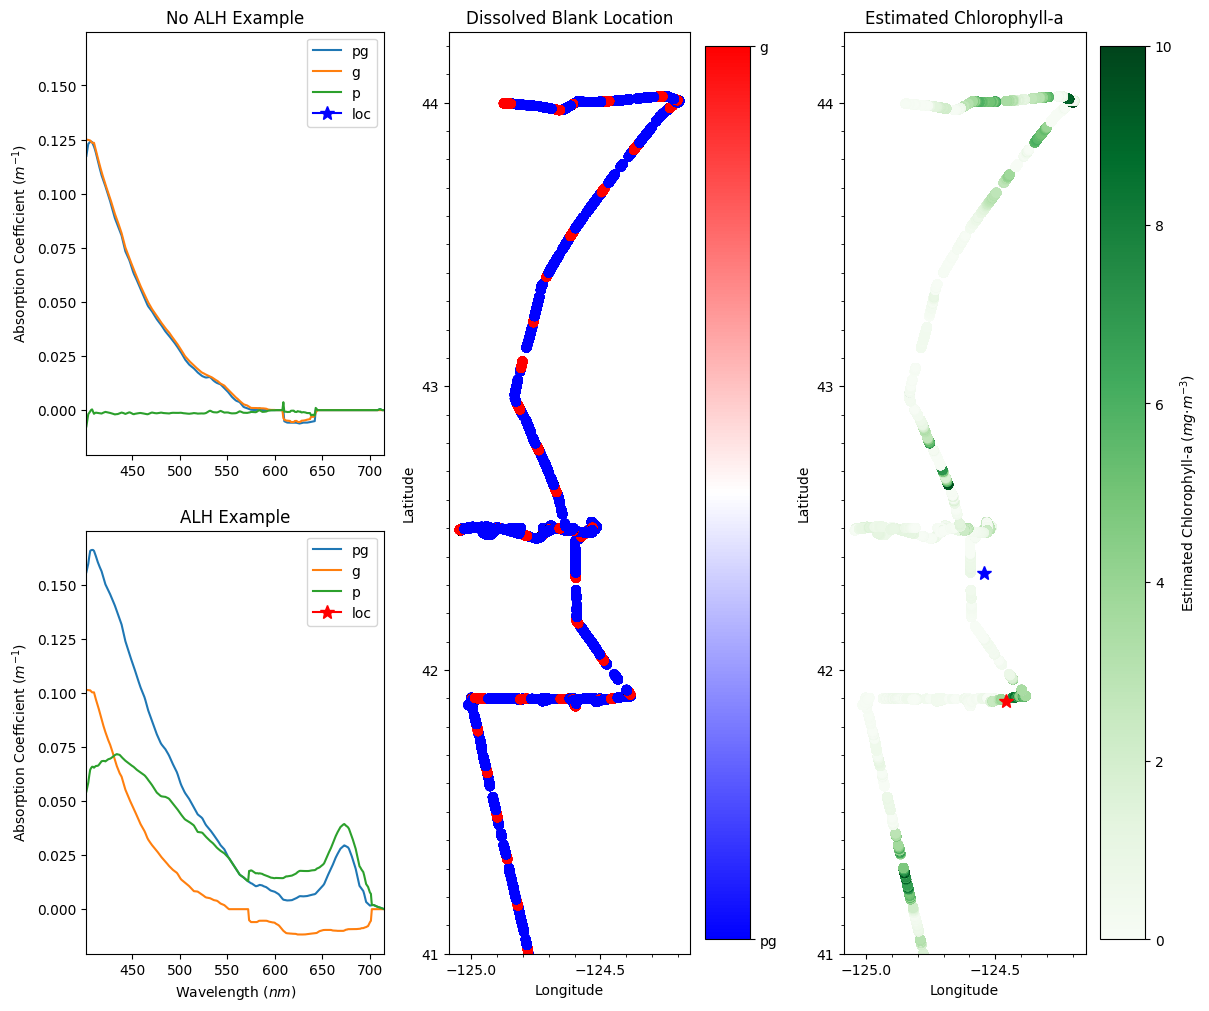

In [21]:
ba = (44.25 - 41)/(acs.longitude.max() - acs.longitude.min())

a650 = a_p.sel(wavelength = 650)
a676 = a_p.sel(wavelength = 676)
a715 = a_p.sel(wavelength = 715)
lat = pg.latitude
lon = pg.longitude
est_chl = np.round(estimate_chl(a650, a676, a715),2)

t1 = datetime(2024,6,3,2,10,23)

#t1 = p.time.values[-85000]
sp1 = a_p.sel(time = t1, method = 'nearest')
sg1 = gi.sel(time = t1, method = 'nearest')
spg1 = pg.sel(time = t1, method = 'nearest')

t2 = datetime(2024,6,2,21,50,23)
#t2 = p.time.values[122000]
sp2 = a_p.sel(time = t2, method = 'nearest')
sg2 = gi.sel(time = t2, method = 'nearest')
spg2 = pg.sel(time = t2, method = 'nearest')


fig = plt.figure(figsize = (12,10), constrained_layout = True)
grid = (2,3)
ax0 = plt.subplot2grid(grid, (0,0), colspan = 1,rowspan = 1)
ax1 = plt.subplot2grid(grid, (1,0), colspan = 1,rowspan = 1, sharex = ax0, sharey = ax0)
ax2 = plt.subplot2grid(grid, (0,1), colspan = 1,rowspan = 2)
ax3 = plt.subplot2grid(grid, (0,2), colspan = 1,rowspan = 2)

ax0.plot(spg1.wavelength, spg1.a_mts_proportional, label = 'pg')
ax0.plot(sg1.wavelength, sg1, label = 'g')
ax0.plot(sp1.wavelength, sp1, label = 'p')
ax0.plot([], [], marker = '*', color = 'blue', markersize = 10, label = 'loc')
ax0.set_xlim(402,715)
ax0.set_ylabel('Absorption Coefficient ($m^{-1}$)')
ax0.legend(loc = 'upper right')

ax1.plot(spg2.wavelength, spg2.a_mts_proportional, label = 'pg')
ax1.plot(sg2.wavelength, sg2, label = 'g')
ax1.plot(sp2.wavelength, sp2, label = 'p')
ax1.plot([], [], marker = '*', color = 'r', markersize = 10, label = 'loc')
ax1.set_ylabel('Absorption Coefficient ($m^{-1}$)')
ax1.set_xlabel('Wavelength ($nm$)')
ax1.legend(loc = 'upper right')

_p = ax2.scatter(acs.longitude, acs.latitude, c = acs.seawater_state,cmap = 'bwr')
cbar = fig.colorbar(_p, ax = ax2, ticks = [0,1])
cbar.ax.set_yticklabels(['pg', 'g'])
ax2.set_box_aspect(ba)

ax2.yaxis.set_major_locator(MultipleLocator(1))
ax2.yaxis.set_minor_locator(MultipleLocator(0.1))
ax2.xaxis.set_major_locator(MultipleLocator(0.5))
ax2.xaxis.set_minor_locator(MultipleLocator(0.1))
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')
ax2.set_ylim(41,44.25)

_p = ax3.scatter(lon, lat, c = est_chl, cmap = 'Greens', vmin = 0, vmax = 10)
fig.colorbar(_p, ax = ax3, label = r'Estimated Chlorophyll-a ($mg{\cdot}m^{-3}$)')
ax3.set_box_aspect(ba)
ax3.plot(spg1.longitude + 0.05, spg1.latitude, marker = '*', color = 'blue', markersize = 10)
ax3.plot(spg2.longitude + 0.05, spg2.latitude, marker = '*', color = 'r', markersize = 10)
ax3.set_ylim(41,44.25)
ax3.yaxis.set_major_locator(MultipleLocator(1))
ax3.yaxis.set_minor_locator(MultipleLocator(0.1))
ax3.xaxis.set_major_locator(MultipleLocator(0.5))
ax3.xaxis.set_minor_locator(MultipleLocator(0.1))
ax3.set_xlabel('Longitude')
ax3.set_ylabel('Latitude')
ax3.set_ylim(41,44.25)

ax0.set_title('No ALH Example')
ax1.set_title('ALH Example')
ax2.set_title('Dissolved Blank Location')
ax3.set_title('Estimated Chlorophyll-a')

plt.savefig('scratch/shimada_acs.jpg', dpi = 600)
